This notebook will specifically use data from the Allen Insitute for Neural Dynamics and show how we can leverage CEBRA to analyse our in-house data.

In [1]:
import sys
import os # my addtion

import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import cebra.data
import torch
import cebra.integrations
import cebra.datasets
from cebra import CEBRA
import torch
import pickle
import utils


from matplotlib.collections import LineCollection
import pandas as pd

## Load the Data

Here we load data from the Fibre Photometry pipeline of 4 Neuromodulators (DA, 5HT, ACh, NE) recorded in the Nucleus Acumbens region. The main neural data will be in the form of dF_F traces of these 4 Neuromodulators (NMs). These will be stored in a 2D array, 'all_nms'.

In [2]:
pd.__version__

'2.0.0'

In [3]:
#pip install pandas==2.0.0

In [3]:
#
df_trials_ses = pickle.load(open('/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/data/CO data/df.pkl', "rb"))

In [4]:
df_trials_ses[['choice_time', 'reward_time']]

,choice_time,reward_time
0,92.321007,92.362000
1,101.023003,NaN
2,108.575996,NaN
3,113.322006,NaN
4,117.152000,NaN
...,...,...
1760,10949.992188,NaN
1761,10954.376953,10954.419922
1762,10960.488281,10960.533203
1763,10965.165039,NaN


In [5]:
# 68% of the values in the reward_time column are null
df_trials_ses['choice_time'].isna()

0       False
1       False
2       False
3       False
4       False
        ...  
1760    False
1761    False
1762    False
1763    False
1764    False
Name: choice_time, Length: 7060, dtype: bool

In [6]:
# download the dictionary containing the traces
traces = pickle.load(open('/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/data/CO data/traces.pkl', "rb"))

In [7]:
# Combine the traces into one 2D array
all_nms = np.array([traces[trace] for trace in traces.keys()])
all_nms = np.transpose(all_nms)

In [8]:
# change it to an array of floats (previously it was an array of object datatype)
all_nms_new = all_nms.astype(np.float64)
all_nms_new.shape

(218572, 4)

In [9]:
# convert it to a tensor (this is probably not necessary but we want it to be as close to the inputs in the previous notebook)
all_nms_tensor = torch.from_numpy(all_nms_new)
all_nms_tensor.shape

torch.Size([218572, 4])

The neural data (4 NMs) is across 218,572 time-steps.

## Create the behavioural /auxiliary variables

These will be the labels we use with CEBRA-Behaviour mode.

In [10]:
# First, get the total number of trials in our data
n_trials = df_trials_ses['reward'].index.max() + 1
n_trials

# Then create a list to hold the individual trial labels
all_labels = []

# And then...at each trial,
for i in range(0,n_trials):

    # get the number of timesteps in the trial
    n_timesteps  = df_trials_ses['NM_no_overlap'].iloc[i].shape[0]

    # make a boolean array indicating each of the timesteps as True(rewarded)/False(unrewarded)
    if df_trials_ses['reward'].iloc[i] == True:
        trial_label = np.ones(n_timesteps).astype(np.bool_)

    elif df_trials_ses['reward'].iloc[i] == False:
        trial_label = np.zeros(n_timesteps).astype(np.bool_)
    
    # append the boolean array to the list of trial labels
    all_labels.append(trial_label)

# Then concatenate the list of arrays containing the trial labels 
labels = np.concatenate(all_labels)

# Finally, compare the length of the label and the neural data
print('length of labels', labels.shape)
print('shape of neural data', all_nms.shape)



length of labels (218572,)
shape of neural data (218572, 4)


In [11]:
# check for random timesteps and see if it's actually the correct reward labels used
np.unique(labels[196:347], return_counts=True)

(array([False]), array([151]))

Here, the example used is the second trial in the session which was unrewarded. (The first trial is 196 timesteps and the second trial is 151 timesteps). You can verify this using **'df_trials_ses['NM_no_overlap'].iloc[0].shape[0]'** for the first trial and **'df_trials_ses['NM_no_overlap'].iloc[1].shape[0]'** for the second trial.

Once we are satisfied with these labels, we proceed to build the CEBRA model.

## Build and train the CEBRA models

In [12]:
# set the maximum number of iterations for training the model
max_iterations = 2000

In [13]:
# build a CEBRA-Time and CEBRA-Behaviour model
cebra_time_model = CEBRA(model_architecture='offset10-model-mse',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='euclidean',
                        conditional='time',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

In [14]:
cebra_behaviour_model = CEBRA(model_architecture='offset10-model-mse',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='euclidean',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

Train the two models

In [15]:
# train the time model (no labels here)
cebra_time_model.fit(all_nms_tensor)

pos:  0.9281 neg:  2.5608 total:  3.4889 temperature:  1.0000: 100%|██████████| 2000/2000 [00:50<00:00, 39.50it/s]


CEBRA(batch_size=512, conditional='time', distance='euclidean',
      max_iterations=2000, model_architecture='offset10-model-mse',
      output_dimension=3, temperature=1, time_offsets=10, verbose=True)

In [16]:
# train the behaviour model (use the labels here)
cebra_behaviour_model.fit(all_nms_tensor,labels)

pos:  0.8696 neg:  2.6167 total:  3.4863 temperature:  1.0000: 100%|██████████| 2000/2000 [00:48<00:00, 41.08it/s]


CEBRA(batch_size=512, conditional='time_delta', distance='euclidean',
      max_iterations=2000, model_architecture='offset10-model-mse',
      output_dimension=3, temperature=1, time_offsets=10, verbose=True)

## Compute Embeddings
Then compute the embeddings from the two trained models

In [17]:
time_embedding = cebra_time_model.transform(all_nms_tensor)

In [18]:
behaviour_embedding = cebra_behaviour_model.transform(all_nms_tensor)

In [19]:
# divide the labels into rewarded and unrewarded
rewarded_ = labels==True
unrewarded_ = labels==False

rewarded_ = rewarded_.flatten()
unrewarded_ = unrewarded_.flatten()

In [20]:
# sanity check - confirm that there's only two possibilities and that they add up to the total # of timesteps
print('Unique values (and their corresponding counts in the labels:',np.unique(unrewarded_, return_counts=True))

print('Embedding (time) shape:',time_embedding.shape)
print('Embedding (behaviour) shape:',behaviour_embedding.shape)

print(np.sum(time_embedding.shape[0] - np.sum(np.unique(unrewarded_, return_counts=True)[1])))

Unique values (and their corresponding counts in the labels: (array([False,  True]), array([ 80450, 138122]))
Embedding (time) shape: (218572, 3)
Embedding (behaviour) shape: (218572, 3)
0


In [21]:
np.sum(time_embedding- behaviour_embedding)

-1165423.0

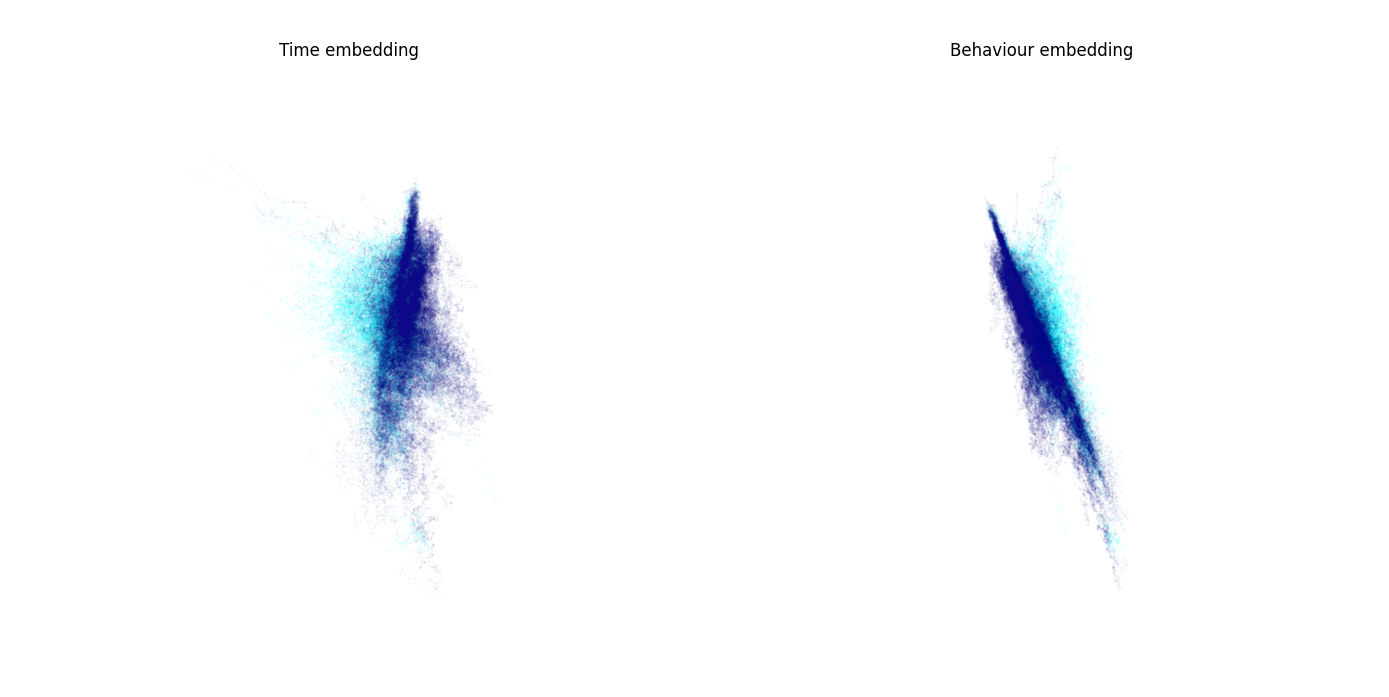

In [87]:
# create a figure and make the plots
fig1 = plt.figure(figsize=(14,8))
gs = gridspec.GridSpec(1, 2, figure=fig1)


ax1 = fig1.add_subplot(gs[0,0], projection='3d')
ax2 = fig1.add_subplot(gs[0,1], projection='3d')
ax1.axis('off')
ax2.axis('off')


# colour maps
colours = ['cool', 'plasma']

# plot the time embedding 
cebra.plot_embedding(embedding=time_embedding[rewarded_,:], embedding_labels=labels[rewarded_],ax=ax1, markersize=0.02, title='Time embedding', cmap=colours[0])
cebra.plot_embedding(embedding=time_embedding[unrewarded_,:], embedding_labels=labels[unrewarded_],ax=ax1, markersize=0.02, title='Time embedding', cmap=colours[1])

# plot the behaviour embedding 
cebra.plot_embedding(embedding=behaviour_embedding[rewarded_,:], embedding_labels=labels[rewarded_],ax=ax2, markersize=0.002, title='Behaviour embedding', cmap=colours[0],)
cebra.plot_embedding(embedding=behaviour_embedding[unrewarded_,:], embedding_labels=labels[unrewarded_],ax=ax2,markersize=0.002, title='Behaviour embedding',  cmap=colours[1])
gs.tight_layout(figure=fig1)


<Axes3D: title={'center': 'CEBRA-Behaviour embedding'}>

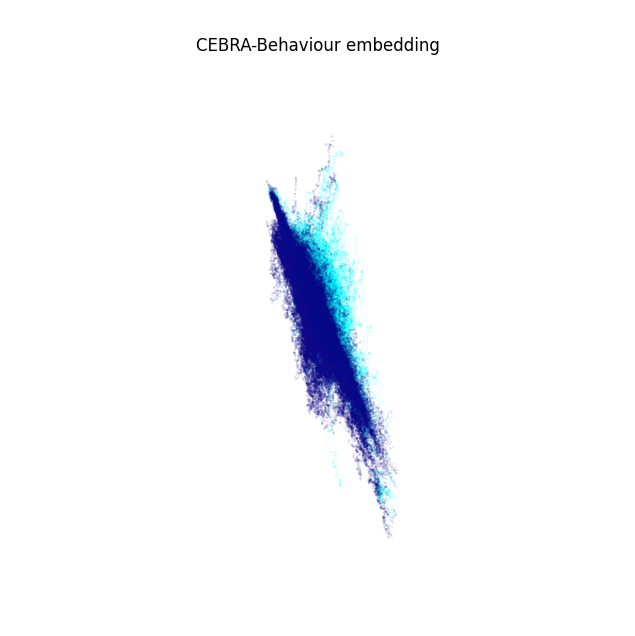

In [92]:
fig_ = plt.figure(figsize=(16,8))

ax0 = fig_.add_subplot(projection='3d')
ax0.axis('off')

# colour maps
colours = ['cool', 'plasma']

# plot the time embedding 
cebra.plot_embedding(embedding=behaviour_embedding[rewarded_,:], embedding_labels=labels[rewarded_],ax=ax0, markersize=0.02, title='CEBRA-Behaviour embedding', cmap=colours[0])
cebra.plot_embedding(embedding=behaviour_embedding[unrewarded_,:], embedding_labels=labels[unrewarded_],ax=ax0, markersize=0.02, title='CEBRA-Behaviour embedding', cmap=colours[1])


If this is correct, there should be a clear clustering of the rewarded (cool/light blue) vs the unrewarded (viridis/purple) trials.

## Verify the result

So it looks like there's two distinct clusters. But let's verify that.

1. View from different angles
2. Use both cosine distance and euclidean distance
3. Use 2D and 3D embeddings

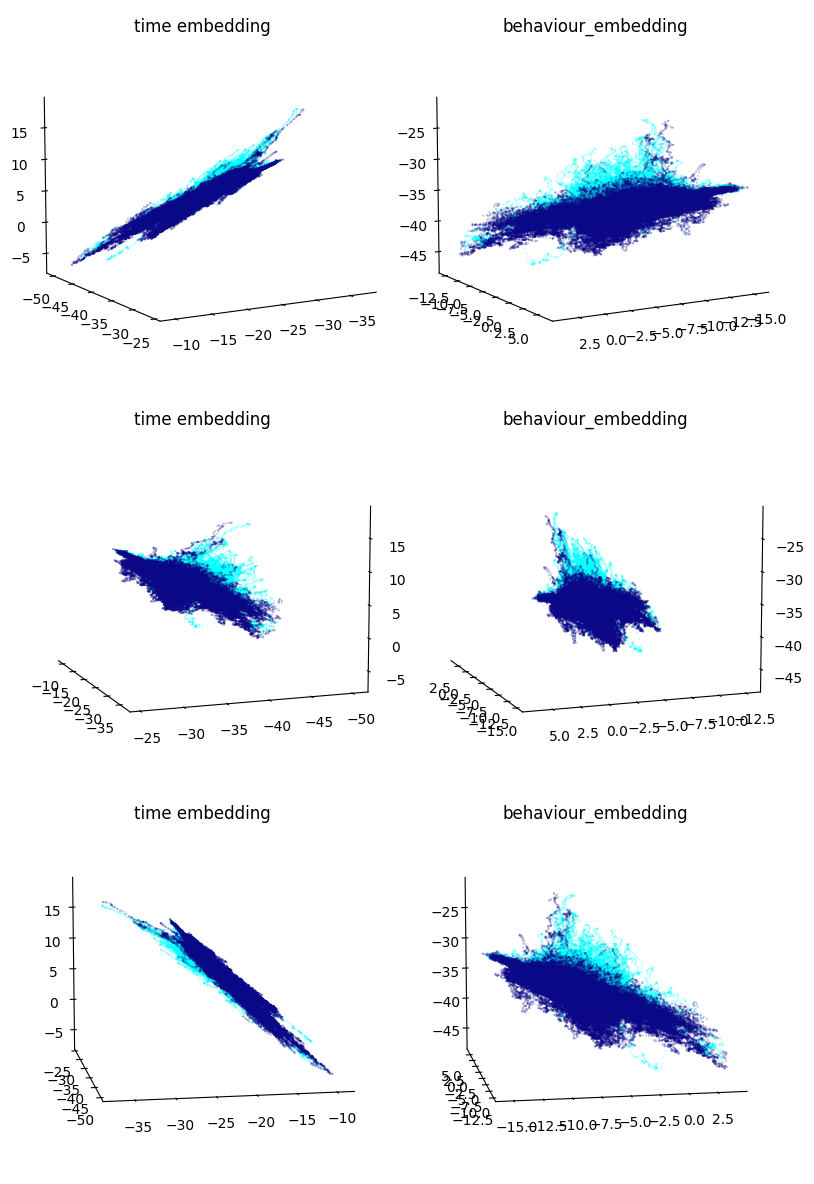

In [23]:
utils.view_embedding(time_embedding, behaviour_embedding,s=0.1, label=labels,label_class= [rewarded_,unrewarded_], titles=['time embedding','behaviour_embedding'])

1. At different angles we see they're actually distinct parts of the embedding.
2. Also, the euclidean embeddings make this more visible as compared to the cosine distance-based embeddings that constrain the dynamics to the surface of the sphere in 3D.

Now let's look at how it looks in 2D

### 2D Embeddings

In [24]:
# CEBRA Time
time_model_2d, time_embedding_2d = utils.base_embed(all_nms_tensor, dimension=2)

  0%|          | 0/2000 [00:00<?, ?it/s]

pos:  0.9635 neg:  2.5966 total:  3.5601 temperature:  1.0000: 100%|██████████| 2000/2000 [00:50<00:00, 39.23it/s]


In [25]:
# CEBRA Behaviour
behaviour_model_2d, behaviour_embedding_2d = utils.base_embed(all_nms_tensor,labels, dimension=2)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
# sanity check - confirm that there's only two possibilities and that they add up to the total # of timesteps
print('Unique values (and their corresponding counts in the labels:',np.unique(unrewarded_, return_counts=True))

print('Embedding (time) shape:',time_embedding_2d.shape)
print('Embedding (behaviour) shape:',behaviour_embedding_2d.shape)

print(np.sum(time_embedding_2d.shape[0] - np.sum(np.unique(unrewarded_, return_counts=True)[1])))

Unique values (and their corresponding counts in the labels: (array([False,  True]), array([ 80450, 138122]))
Embedding (time) shape: (218572, 2)
Embedding (behaviour) shape: (218572, 2)
0


<Axes: title={'center': 'Behaviour embedding'}>

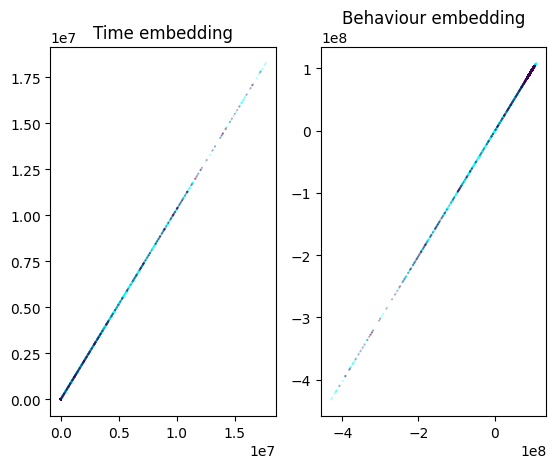

In [ ]:
# create a figure and make the plots
fig1 = plt.figure()
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

# plot the time embedding 
cebra.plot_embedding(embedding=time_embedding_2d[rewarded_,:], embedding_labels=labels[rewarded_],ax=ax1, markersize=0.2, title='Time embedding', cmap='cool')
cebra.plot_embedding(embedding=time_embedding_2d[unrewarded_,:], embedding_labels=labels[unrewarded_],ax=ax1, markersize=0.2, title='Time embedding', cmap='viridis')

# plot the behaviour embedding 
cebra.plot_embedding(embedding=behaviour_embedding_2d[rewarded_,:], embedding_labels=labels[rewarded_],ax=ax2, markersize=0.2, title='Behaviour embedding', cmap='cool')
cebra.plot_embedding(embedding=behaviour_embedding_2d[unrewarded_,:], embedding_labels=labels[unrewarded_],ax=ax2,markersize=0.2, title='Behaviour embedding', cmap='viridis')

3. So it looks like the distinction is not very visible in 2D...not sure this makes sense, but my intuition is that there's just not enough dimensions to describe what's different?